Credits: inspired to introduction in
Raschka, Machine Learning with PyTorch, Chap 18

## A (Very) Preliminary Introuduction to Graph Neural Networks

GNNs have been an area of rapid development in recent years. Ac- cording to the State of AI report from 2021 (https://www.stateof.ai/2021-report-launch.html)

GNN are used for

*   Text classification (https://arxiv.org/abs/1710.10903)

*   Recommendation systems (https://arxiv.org/abs/1704.06803)

* Traffic forecasting (https://arxiv.org/abs/1707.01926)

* Drug discovery (https://arxiv.org/abs/1806.02473)



GNN (Graph Neural Network) is a general term for any neural network designed to operate on graph-structured data. It encompasses various architectures that can learn representations of nodes, edges, or entire graphs by aggregating information across graph structures.

GCN (Graph Convolutional Network) is a specific type of GNN that applies convolutional operations to graphs. It’s inspired by the concept of convolution in image processing and operates by aggregating a node's features with its neighbors' features, often using a normalized adjacency matrix to preserve structural information.

GCNs are more widely recognized and used, especially since the original GCN paper by Kipf and Welling (2016) made the approach popular for tasks like node classification and link prediction.
However, GNN is a broader category, and newer architectures (like Graph Attention Networks or GATs) are also popular under the GNN umbrella for specific applications and improvements on the basic GCN model.

There are many different kinds of graph con- volutions, and the development of new graph convolutions is a very active area of research.

### Introduction to graph data

In [6]:
from IPython.display import Image

img_url = "https://raw.githubusercontent.com/cfteach/NNDL_DATA621/94de99576a12d36a84046589e11722516d240af6/DATA621/DATA621/images/im1.png"


Image(url=img_url, width = 600)


#### Undirected graphs

An undirected graph consists of nodes (in graph theory also often called vertices) that are connected via edges where the order of the nodes and their connection does not matter.

In [8]:
img_url = "https://raw.githubusercontent.com/cfteach/NNDL_DATA621/94de99576a12d36a84046589e11722516d240af6/DATA621/DATA621/images/im2.png"


Image(url=img_url, width = 1000)

#### Directed graphs

Directed graphs, in contrast to undirected graphs discussed in the previous section, connect nodes via directed edges. Mathematically they are defined in the same way as an undirected graph, except that $E$, the set of edges, is a set of ordered pairs. Therefore, element $x_{ij}$ of A does need not to be equal to $x_{ji}$.

In [9]:
img_url = "https://raw.githubusercontent.com/cfteach/NNDL_DATA621/94de99576a12d36a84046589e11722516d240af6/DATA621/DATA621/images/im3.png"


Image(url=img_url, width = 600)

#### Labeled graphs

### Representing molecules as graphs

Many graphs we are interested in working with have additional information associated with each of their nodes and edges. For example, if you consider the caffeine molecule below.
Each node (vertex $V$) has $f_{V}$ features.

In [10]:
img_url = "https://raw.githubusercontent.com/cfteach/NNDL_DATA621/94de99576a12d36a84046589e11722516d240af6/DATA621/DATA621/images/im4.png"


Image(url=img_url, width = 600)

### Understanding graph convolutions

To understand the motivation behind using graph convolutions, we have to do one step back and think of CNN.

In the CNN, the filter can be viewed as a "detector" for a specific feature. This approach to feature detection is well-suited for images for several reasons:



*   **Shift-invariance**: We can still recognize a feature in an image regardless of where it is located (for example, after translation). A cat can be recognized as a cat whether it is in the top left, bottom right, or another part of an image.

*   **Locality**: Nearby pixels are closely related.

*   **Hierarchy**: Larger parts of an image can often be broken down into combinations of associated smaller parts. A cat has a head and legs; the head has eyes and a nose; the eyes have pupils and irises.



Another reason convolutions are well-suited for processing images is that the number of trainable parameters does not depend on the dimensionality of the input. You could train a series of 3×3 con- volutional filters on, for example, a 256×256 or a 9×9 image.

**Like images, graphs also have natural properties that justify a convolutional approach.** Both approaches share the locality property: a node that is one edge away is more likely to be related than a node five edges away. For example, in a citation graph, a directly cited publication, which would be one edge away, is more likely to have similar subject matter than a publication with multiple degrees of separation.


A strict property for graph data is **permutation invariance**, which means that the ordering of the nodes does not affect the output.



In [12]:
img_url = "https://raw.githubusercontent.com/cfteach/NNDL_DATA621/94de99576a12d36a84046589e11722516d240af6/DATA621/DATA621/images/im5.png"


Image(url=img_url, width = 1000)

**The same graph can be represented by multiple adjacency**

### Implementing a basic graph convolution

In [14]:
img_url = "https://raw.githubusercontent.com/cfteach/NNDL_DATA621/94de99576a12d36a84046589e11722516d240af6/DATA621/DATA621/images/im6.png"


Image(url=img_url, width = 1000)

In [2]:
import networkx as nx
import numpy as np

In [3]:
G = nx.Graph()

#Hex codes for colors if we draw graph
blue, orange, green = "#1f77b4", "#ff7f0e","#2ca02c"

G.add_nodes_from([(1, {"color": blue}),
                  (2, {"color": orange}),
                  (3, {"color": blue}),
                  (4, {"color": green})])

G.add_edges_from([(1, 2),(2, 3),(1, 3),(3, 4)])
A = np.asarray(nx.adjacency_matrix(G).todense())
print(A)

[[0 1 1 0]
 [1 0 1 0]
 [1 1 0 1]
 [0 0 1 0]]


In [11]:
def build_graph_color_label_representation(G,mapping_dict):
    one_hot_idxs = np.array([mapping_dict[v] for v in
                             nx.get_node_attributes(G, 'color').values()])
    one_hot_encoding = np.zeros((one_hot_idxs.size,len(mapping_dict)))
    one_hot_encoding[np.arange(one_hot_idxs.size),one_hot_idxs] = 1
    return one_hot_encoding

X = build_graph_color_label_representation(G, {green: 0, blue: 1, orange: 2})
print(X)

[[0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


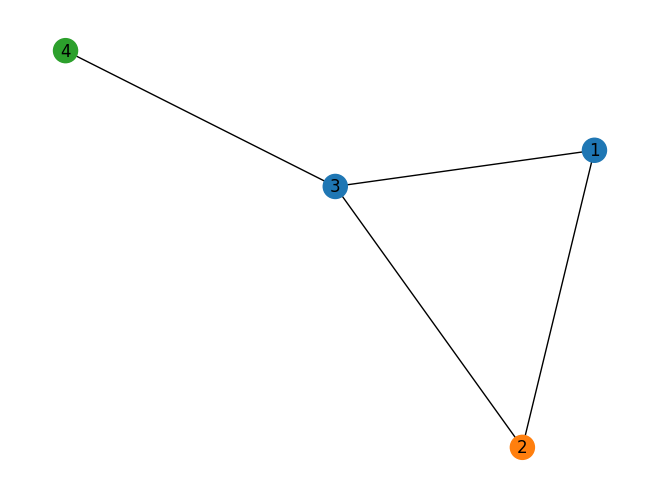

In [15]:
color_map = nx.get_node_attributes(G, 'color').values()

nx.draw(G, with_labels=True, node_color=color_map)

Each node in a graph has a set of features represented by embedding in a matrix $X$. $x_{i}$ is the feature vector for node $i$.


For our example implementation, the graph convolution will take the following form:


$
\mathbf{x}_i' = \mathbf{x}_i \mathbf{W}_1 + \sum_{j \in \mathcal{N}(i)} \mathbf{x}_j \mathbf{W}_2 + \mathbf{b}
$

where:
- $\mathbf{x}_i'$ is the updated embedding for node $i$,
- $\mathbf{W}_1$ and $\mathbf{W}_2$ are $f_{\text{in}} \times f_{\text{out}}$ matrices of learnable filter weights,
- $\mathbf{b}$ is a learnable bias vector of length $f_{\text{out}}$.




In [16]:
img_url = "https://raw.githubusercontent.com/cfteach/NNDL_DATA621/94de99576a12d36a84046589e11722516d240af6/DATA621/DATA621/images/im7.png"


Image(url=img_url, width = 800)

The graph convolution is more effective when there is a **locality property**.


By stacking other convolution layers, the updated embeddings can incorporate information from nodes that were originally edges away.




In [ ]:
f_in, f_out = X.shape[1], 6
W_1 = np.random.rand(f_in, f_out)
W_2 = np.random.rand(f_in, f_out)
h = np.dot(X,W_1) + np.dot(np.dot(A, X), W_2)

The following notation is inherited from ''Neural Message Passing for Quantum Chemistry'' by Justin Gilmer and colleagues, 2017, https://arxiv.org/abs/1704.01212.



In [17]:
img_url = "https://raw.githubusercontent.com/cfteach/NNDL_DATA621/94de99576a12d36a84046589e11722516d240af6/DATA621/DATA621/images/im8.png"


Image(url=img_url, width = 600)

### Implementing a GNN in PyTorch

#### Defining the NodeNetwork model

In [ ]:
import networkx as nx
import torch
from torch.nn.parameter import Parameter
import numpy as np
import torch.nn.functional as F

In [ ]:
class NodeNetwork(torch.nn.Module):

    def __init__(self, input_features):
        super().__init__()

        self.conv_1 = BasicGraphConvolutionLayer(input_features, 32)
        self.conv_2 = BasicGraphConvolutionLayer(32, 32)
        self.fc_1 = torch.nn.Linear(32, 16)
        self.out_layer = torch.nn.Linear(16, 2)

    def forward(self, X, A,batch_mat):
        x = self.conv_1(X, A).clamp(0)
        x = self.conv_2(x, A).clamp(0)
        output = global_sum_pool(x, batch_mat)
        output = self.fc_1(output)
        output = self.out_layer(output)
        return F.softmax(output, dim=1)

As we will see, `batch_mat` indicates which nodes belong to which graph in a bacth of graphs (each with different dimensions)






The following gives an idea of what we want to achieve.

In [18]:
img_url = "https://raw.githubusercontent.com/cfteach/NNDL_DATA621/94de99576a12d36a84046589e11722516d240af6/DATA621/DATA621/images/im9.png"


Image(url=img_url, width = 600)

### Coding the NodeNetwork’s graph convolution layer

In [ ]:
class BasicGraphConvolutionLayer(torch.nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.W2 = Parameter(torch.rand(
             (in_channels, out_channels), dtype=torch.float32))
        self.W1 = Parameter(torch.rand(
             (in_channels, out_channels), dtype=torch.float32))

        self.bias = Parameter(torch.zeros(
                 out_channels, dtype=torch.float32))

    def forward(self, X, A):
        potential_msgs = torch.mm(X, self.W2)
        propagated_msgs = torch.mm(A, potential_msgs)
        root_update = torch.mm(X, self.W1)
        output = propagated_msgs + root_update + self.bias
        return output

### Adding a global pooling layer to deal with varying graph sizes

The following `global_sum_pool` sums all the node embeddings of a graph

In [1]:
def global_sum_pool(X, batch_mat):
    if batch_mat is None or batch_mat.dim() == 1:
        return torch.sum(X, dim=0).unsqueeze(0)
    else:
        return torch.mm(batch_mat, X)   #[num_graphs, feature_dim]


#batch_mat[i,j] means node j belongs to graph i
#batch_mat [num_graphs, num_nodes]
# X [num_nodes, feature_dim]


The following si a simplified GCN with only W1. To give an idea of how it operates with batches.


In [20]:
img_url = "https://raw.githubusercontent.com/cfteach/NNDL_DATA621/94de99576a12d36a84046589e11722516d240af6/DATA621/DATA621/images/im10.png"


Image(url=img_url, width = 1000)

In [ ]:
# creates a batch indicator matrix based on a list graph_sizes

# the following works at the batch level

def get_batch_tensor(graph_sizes):  #graph_sizes is a list where each element is the size of a graph
    starts = [sum(graph_sizes[:idx]) for idx in range(len(graph_sizes))]
    stops = [starts[idx]+graph_sizes[idx] for idx in range(len(graph_sizes))]
    tot_len = sum(graph_sizes)
    batch_size = len(graph_sizes)
    batch_mat = torch.zeros([batch_size, tot_len]).float() # tot_len is the number of nodes
    for idx, starts_and_stops in enumerate(zip(starts, stops)):  #idx is the graph index in the batch
        start = starts_and_stops[0]
        stop = starts_and_stops[1]
        batch_mat[idx, start:stop] = 1
    return batch_mat

In [ ]:
# the following combines mutliple graphs in a batch into a single unified representation

def collate_graphs(batch):
    adj_mats = [graph['A'] for graph in batch] #graph['A'] extracts the adjacency matrix
    sizes = [A.size(0) for A in adj_mats] # number of nodes in each graph
    tot_size = sum(sizes) # tot number of nodes in the batch
    # create batch matrix
    batch_mat = get_batch_tensor(sizes)  #[batch_size, tot_size]
    # combine feature matrices
    feat_mats = torch.cat([graph['X'] for graph in batch],dim=0)
    # combine labels
    labels = torch.cat([graph['y'] for graph in batch], dim=0)
    # combine adjacency matrices
    batch_adj = torch.zeros([tot_size, tot_size], dtype=torch.float32)
    accum = 0
    for adj in adj_mats:
        g_size = adj.shape[0]
        batch_adj[accum:accum+g_size, accum:accum+g_size] = adj
        accum = accum + g_size
    repr_and_label = {
            'A': batch_adj, # block diagonal adjacency matrix in the batch
            'X': feat_mats, # combied feature matrix
            'y': labels,
            'batch' : batch_mat}

    return repr_and_label

### Preparing the DataLoader

In [ ]:
def get_graph_dict(G, mapping_dict):
    # build dictionary representation of graph G
    A = torch.from_numpy(np.asarray(nx.adjacency_matrix(G).todense())).float()
    # build_graph_color_label_representation() was introduced with the first example graph
    X = torch.from_numpy(build_graph_color_label_representation(G,mapping_dict)).float()
    # kludge since there is not specific task for this example
    y = torch.tensor([[1, 0]]).float()  # one-hot encoded
    return {'A': A, 'X': X, 'y': y, 'batch': None}

# building 4 graphs to treat as a dataset

blue, orange, green = "#1f77b4", "#ff7f0e","#2ca02c"
mapping_dict = {green: 0, blue: 1, orange: 2}

G1 = nx.Graph()
G1.add_nodes_from([(1, {"color": blue}),
                   (2, {"color": orange}),
                   (3, {"color": blue}),
                   (4, {"color": green})])
G1.add_edges_from([(1, 2), (2, 3),(1, 3), (3, 4)])
G2 = nx.Graph()
G2.add_nodes_from([(1, {"color": green}),
                   (2, {"color": green}),
                   (3, {"color": orange}),
                   (4, {"color": orange}),
                   (5,{"color": blue})])
G2.add_edges_from([(2, 3),(3, 4),(3, 1),(5, 1)])
G3 = nx.Graph()
G3.add_nodes_from([(1, {"color": orange}),
                   (2, {"color": orange}),
                   (3, {"color": green}),
                   (4, {"color": green}),
                   (5, {"color": blue}),
                   (6, {"color":orange})])
G3.add_edges_from([(2, 3), (3, 4), (3, 1), (5, 1), (2, 5), (6, 1)])
G4 = nx.Graph()
G4.add_nodes_from([(1, {"color": blue}), (2, {"color": blue}), (3, {"color": green})])
G4.add_edges_from([(1, 2), (2, 3)])
graph_list = [get_graph_dict(graph,mapping_dict) for graph in [G1, G2, G3, G4]]

In [22]:
img_url = "https://raw.githubusercontent.com/cfteach/NNDL_DATA621/94de99576a12d36a84046589e11722516d240af6/DATA621/DATA621/images/im11.png"


Image(url=img_url, width = 1000)

In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


class ExampleDataset(Dataset):

    # Simple PyTorch dataset that will use our list of graphs
    def __init__(self, graph_list):
        self.graphs = graph_list

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self,idx):
        mol_rep = self.graphs[idx]
        return mol_rep

In [ ]:
dset = ExampleDataset(graph_list)
# Note how we use our custom collate function
loader = DataLoader(dset, batch_size=2, shuffle=False, collate_fn=collate_graphs)

### Using the NodeNetwork to make "predictions"

No training yet. We just familiarized with working with graph data.

In [ ]:
torch.manual_seed(123)
node_features = 3
net = NodeNetwork(node_features)

In [ ]:
batch_results = []

for b in loader:
    batch_results.append(net(b['X'], b['A'], b['batch']).detach())

G1_rep = dset[1]
G1_single = net(G1_rep['X'], G1_rep['A'], G1_rep['batch']).detach()

G1_batch = batch_results[0][1]
torch.all(torch.isclose(G1_single, G1_batch))

tensor(True)